Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Accuracy: 0.882

Final Model Evaluation
Accuracy: 0.8703

Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.82      0.87       101
        True       0.81      0.93      0.87        84

    accuracy                           0.87       185
   macro avg       0.87      0.88      0.87       185
weighted avg       0.88      0.87      0.87       185



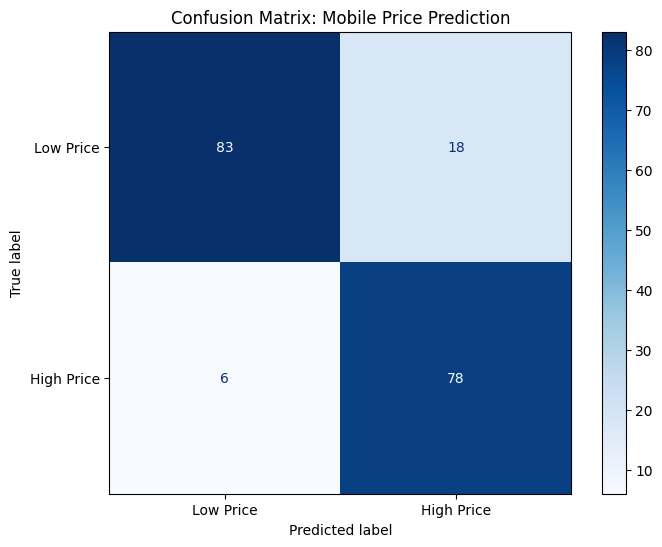

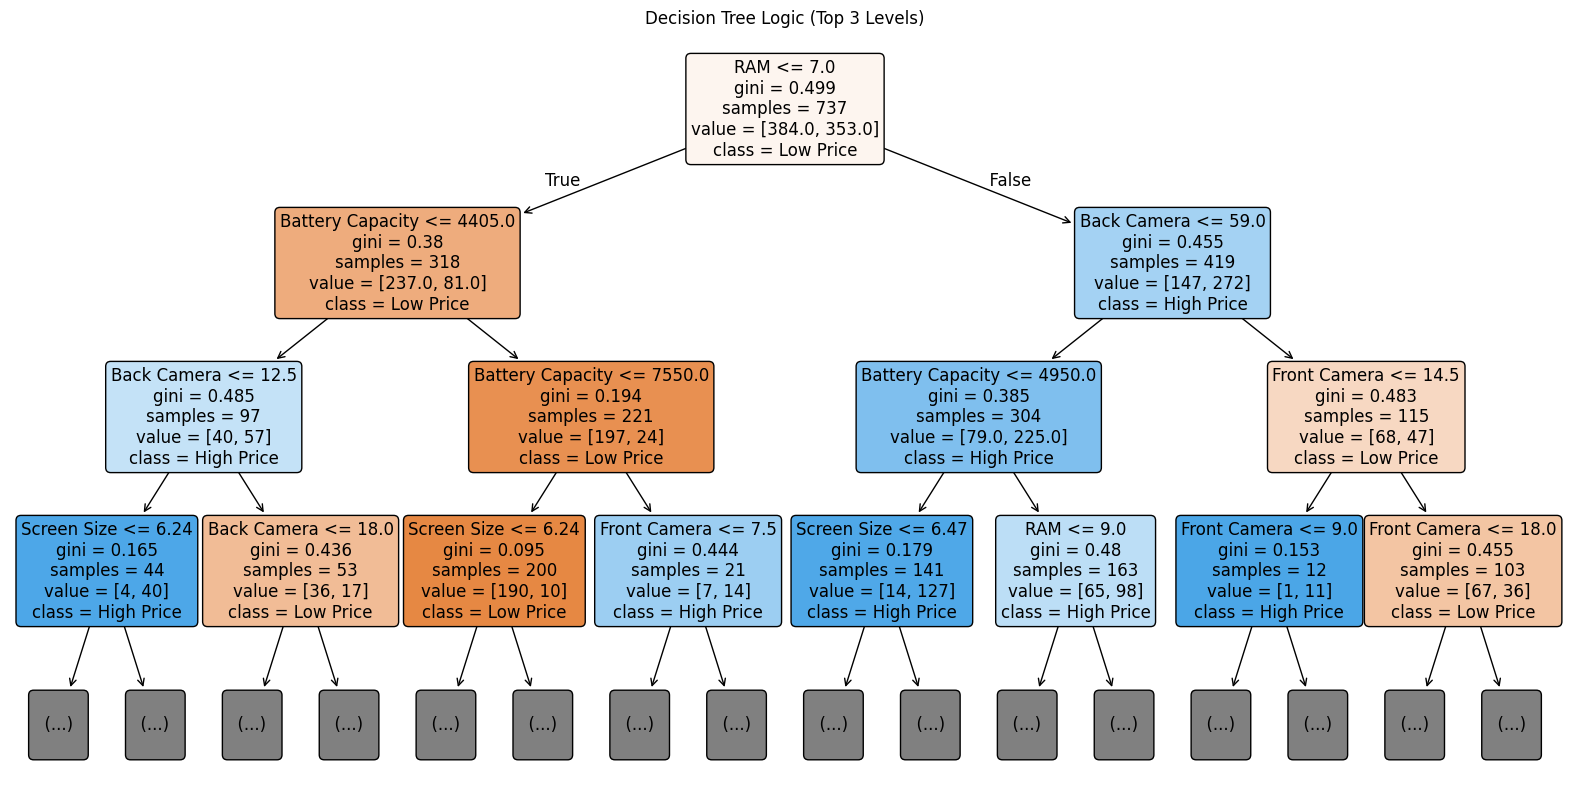

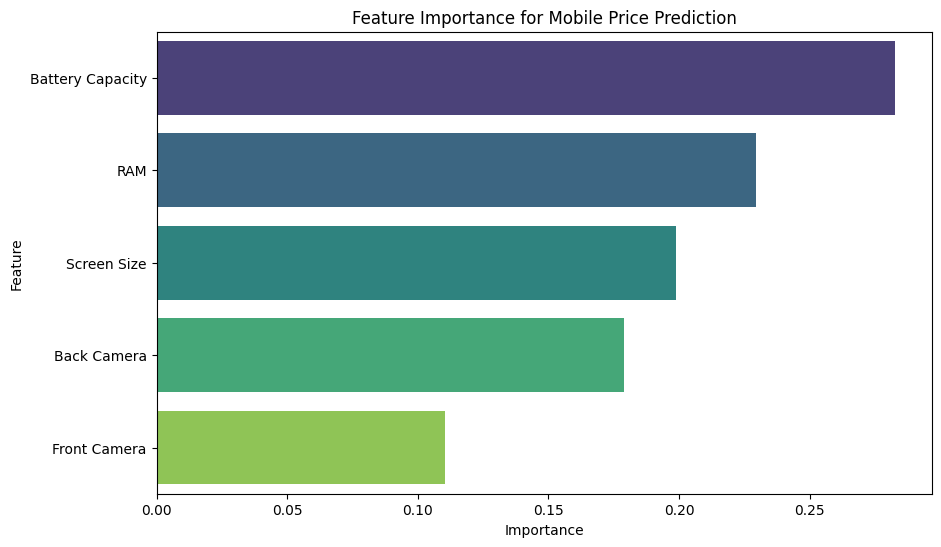

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# =========================
# 1. Load & Clean Data
# =========================
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path, encoding='latin1')
    df.columns = df.columns.str.strip()

    def clean_ram(value):
        nums = re.findall(r'\d+', str(value))
        nums = list(map(int, nums))
        return sum(nums) / len(nums) if nums else None

    df['RAM'] = df['RAM'].astype(str).apply(clean_ram).astype(float)

    df['Battery Capacity'] = (
        df['Battery Capacity']
        .astype(str)
        .str.replace(',', '', regex=False)
        .str.extract(r'(\d+)')[0]
        .astype(float)
    )

    for col in ['Front Camera', 'Back Camera']:
        df[col] = df[col].astype(str).str.extract(r'(\d+)')[0].astype(float)

    df['Screen Size'] = (
        df['Screen Size']
        .astype(str)
        .str.replace('inches', '')
        .str.strip()
    )
    df['Screen Size'] = pd.to_numeric(df['Screen Size'], errors='coerce')

    df['Price'] = (
        df['Launched Price (USA)']
        .astype(str)
        .str.replace(',', '', regex=False)
        .str.extract(r'(\d+)')[0]
        .astype(float)
    )

    df = df.dropna(subset=[
        'RAM','Battery Capacity','Front Camera',
        'Back Camera','Screen Size','Price'
    ])

    return df


df = load_and_clean_data("dataset.csv")

# =========================
# 2. Features & Target
# =========================
X = df[['RAM', 'Battery Capacity', 'Screen Size',
        'Front Camera', 'Back Camera']]

y = df['Price'] > df['Price'].median()

# =========================
# 3. Train-Test Split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================
# 4. Decision Tree + Hyperparameter Tuning
# =========================
dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", round(grid_search.best_score_, 4))

# =========================
# 5. Evaluation
# =========================
y_pred = best_model.predict(X_test)

print("\nFinal Model Evaluation")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# =========================
# 6. Confusion Matrix
# =========================
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Low Price', 'High Price']
)

fig, ax = plt.subplots(figsize=(8,6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix: Mobile Price Prediction")
plt.show()

# =========================
# 7. Decision Tree Diagram (Top Levels)
# =========================
plt.figure(figsize=(20,10))
plot_tree(
    best_model,
    max_depth=3,
    feature_names=X.columns,
    class_names=['Low Price', 'High Price'],
    filled=True,
    rounded=True,
    fontsize=12
)
plt.title("Decision Tree Logic (Top 3 Levels)")
plt.show()

# =========================
# 8. Feature Importance Plot
# =========================
importances = best_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',
    data=feature_importance_df,
    palette='viridis',
    legend=False
plt.title("Feature Importance for Mobile Price Prediction")
plt.show()

Random Forest Accuracy: 0.9135

Classification Report (Random Forest):
              precision    recall  f1-score   support

       False       0.94      0.90      0.92       101
        True       0.89      0.93      0.91        84

    accuracy                           0.91       185
   macro avg       0.91      0.91      0.91       185
weighted avg       0.91      0.91      0.91       185



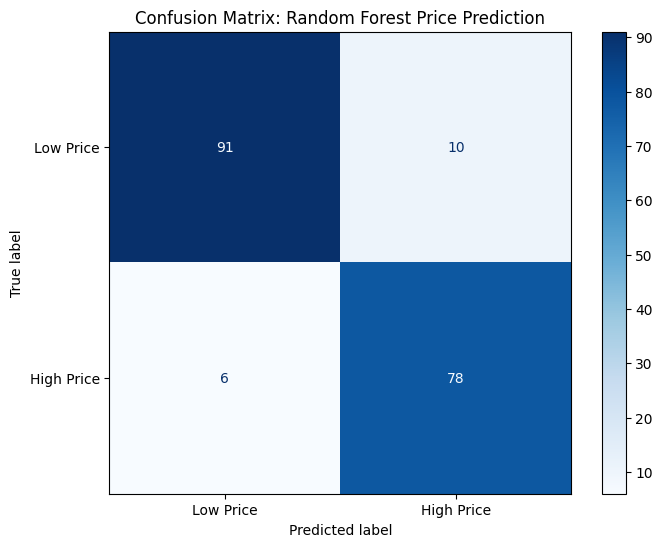

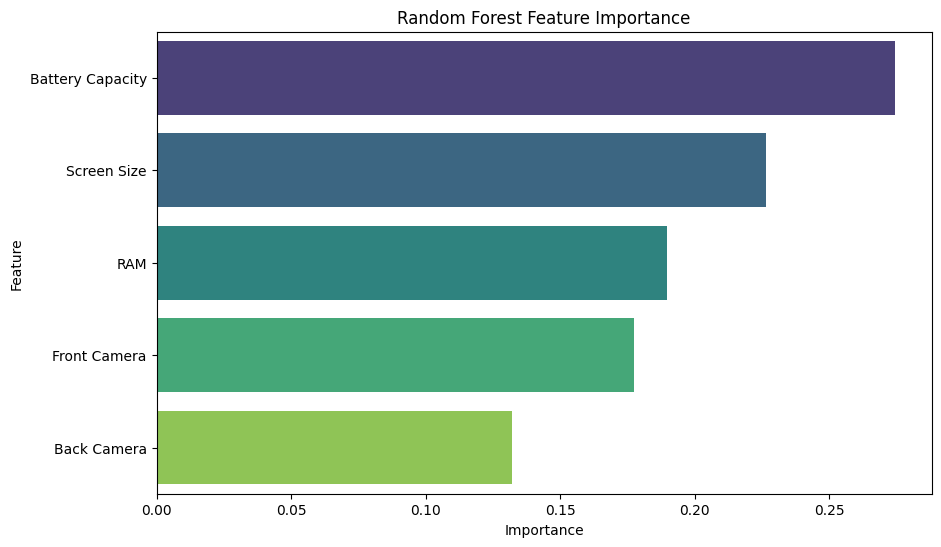

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# =========================
# Random Forest Model
# =========================
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# =========================
# Predictions
# =========================
rf_pred = rf.predict(X_test)

# =========================
# Evaluation
# =========================
rf_acc = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", round(rf_acc, 4))

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, rf_pred))

# =========================
# Confusion Matrix
# =========================
cm = confusion_matrix(y_test, rf_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Low Price', 'High Price']
)

fig, ax = plt.subplots(figsize=(8,6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix: Random Forest Price Prediction")
plt.show()

# =========================
# Feature Importance Plot
# =========================
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Importance',
    y='Feature',
    hue='Feature', # Added hue
    data=feature_importance_df,
    palette='viridis',
    legend=False # Added legend=False
)
plt.title("Random Forest Feature Importance")
plt.show()